In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{3}"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torchvision import transforms
import joblib
from torchsummary import summary
import pytorch_ssim
import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initial settings

In [3]:
lr=0.001
batch_size=32

ntimesteps = 499

t0 = time.time()

print(t0)

root_path = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/'

1708096175.6583543


## Load data

In [4]:
datasetFolder = 'Flow_Data'
xysize = 256

samples = []
for i in range(ntimesteps):
    s = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/InterpolatedResult256/InterpolatedResult256Raw/FpB_Interpolated_t{}_Velocity_{}_{}.npy'.format(
        i, xysize, xysize))
    samples.append(s)
    print(s.shape)

(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 25

In [5]:
concatenated_data = np.stack(samples, axis=0)
print(concatenated_data.shape)

(499, 2, 256, 256)


## Create data loader

In [6]:
dataloader = DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

## Define the model

In [8]:
fist_hidden_layer = 16
second_hidden_layer = 32
latent_channel_number = 8
activation = nn.LeakyReLU(negative_slope=0.2)


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            activation,
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            activation,
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  # Change kernel_size and stride to 2
            activation,
            nn.Conv2d(fist_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  # Change kernel_size and stride to 2
            activation
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  # Change kernel_size and stride to 2
            activation,
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  # Change kernel_size and stride to 2
            activation,
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            activation,
            nn.ConvTranspose2d(fist_hidden_layer, 2, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (2,256, 256))
summary(autoencoder, (2,384, 384))
summary(autoencoder, (2,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             144
         LeakyReLU-2         [-1, 16, 128, 128]               0
         LeakyReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4           [-1, 32, 64, 64]           2,080
         LeakyReLU-5           [-1, 32, 64, 64]               0
         LeakyReLU-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 65, 65]           2,064
         LeakyReLU-8           [-1, 16, 65, 65]               0
         LeakyReLU-9           [-1, 16, 65, 65]               0
           Conv2d-10            [-1, 8, 64, 64]             520
        LeakyReLU-11            [-1, 8, 64, 64]               0
        LeakyReLU-12            [-1, 8, 64, 64]               0
  ConvTranspose2d-13           [-1, 16, 65, 65]             528
        LeakyReLU-14           [-1, 16,

## Train the model

In [34]:
# Specify the IDs of the GPUs you want to use
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

# Initialize a new run
wandb.init(project="compression")

# If there are multiple GPUs, wrap the model with nn.DataParallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    autoencoder = nn.DataParallel(autoencoder)

# Instantiate the model, loss function, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss works well for image reconstruction
# criterion = pytorch_ssim.SSIM(window_size = 11)  # Use SSIM loss
# def ssim_multichannel(img1, img2, window_size=11):
#     # Assume img1 and img2 are 4D tensors [batch_size, channels, height, width]
#     ssim_sum = 0
#     for i in range(img1.shape[1]):
#         ssim_sum += pytorch_ssim.ssim(img1[:, i, :, :].unsqueeze(1), img2[:, i, :, :].unsqueeze(1), window_size=window_size)
#         print(i)
#     return ssim_sum / img1.shape[1]  # Average over channels

optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

num_epochs = 1200

# Optionally, you can add the following line to watch your model in wandb interface
wandb.watch(autoencoder)

# Training loop
for epoch in range(num_epochs):
    for data in dataloader:
        inputs = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        # loss = 1 - ssim_multichannel(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Log the loss to wandb
    wandb.log({"loss": loss.item()})

print("Training time:", time.time()-t0)

# Save the model weights to wandb
torch.save(autoencoder.state_dict(), "autoencoder.pth")
wandb.save("autoencoder.pth")

# Log the model's architecture
wandb.config.model_architecture = str(autoencoder)

# Create a new artifact
artifact = wandb.Artifact('model', type='model')

# Add the file to the artifact
artifact.add_file('autoencoder.pth')

# Save the artifact to Weights & Biases
wandb.log_artifact(artifact)

loss,█▄▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.04235


2024-02-14 20:38:47.165883: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch [1/1200], Loss: 1.1790
Epoch [2/1200], Loss: 0.8535
Epoch [3/1200], Loss: 0.5593
Epoch [4/1200], Loss: 0.5046
Epoch [5/1200], Loss: 0.5039
Epoch [6/1200], Loss: 0.4014
Epoch [7/1200], Loss: 0.3767
Epoch [8/1200], Loss: 0.2966
Epoch [9/1200], Loss: 0.2119
Epoch [10/1200], Loss: 0.1839
Epoch [11/1200], Loss: 0.1733
Epoch [12/1200], Loss: 0.1566
Epoch [13/1200], Loss: 0.1456
Epoch [14/1200], Loss: 0.1410
Epoch [15/1200], Loss: 0.1446
Epoch [16/1200], Loss: 0.1396
Epoch [17/1200], Loss: 0.1315
Epoch [18/1200], Loss: 0.1210
Epoch [19/1200], Loss: 0.1168
Epoch [20/1200], Loss: 0.1104
Epoch [21/1200], Loss: 0.1023
Epoch [22/1200], Loss: 0.0996
Epoch [23/1200], Loss: 0.1003
Epoch [24/1200], Loss: 0.0915
Epoch [25/1200], Loss: 0.0934
Epoch [26/1200], Loss: 0.0887
Epoch [27/1200], Loss: 0.0889
Epoch [28/1200], Loss: 0.0852
Epoch [29/1200], Loss: 0.0811
Epoch [30/1200], Loss: 0.0838
Epoch [31/1200], Loss: 0.0817
Epoch [32/1200], Loss: 0.0815
Epoch [33/1200], Loss: 0.0820
Epoch [34/1200], Lo

## Load saved model

In [10]:
run = wandb.init()
artifact = run.use_artifact('guodh/compression/model:v19', type='model')
artifact_dir = artifact.download()

# Load the model
autoencoder = Autoencoder()

# Load the model state dictionary from the downloaded artifact
autoencoder.load_state_dict(torch.load(os.path.join(artifact_dir, "autoencoder.pth")))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guodh5 (guodh). Use `wandb login --relogin` to force relogin
2024-02-16 15:10:37.422135: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<All keys matched successfully>

## Generate result plots

(2, 256, 256) 131072
latent space shape torch.Size([1, 8, 64, 64]) 32768
(1, 2, 256, 256)


<Figure size 432x288 with 0 Axes>

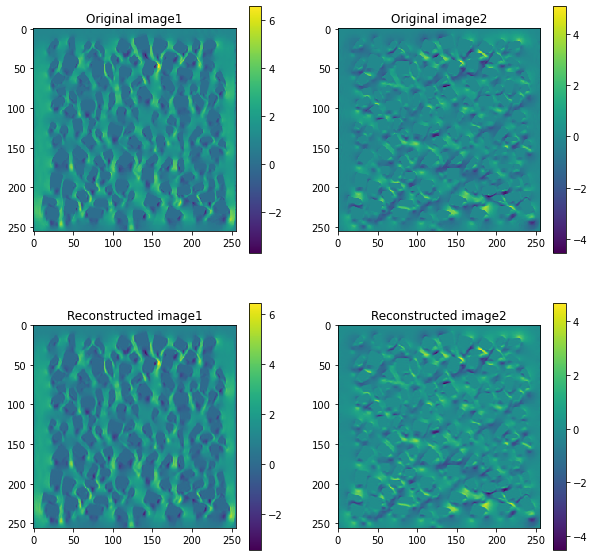

In [11]:
autoencoder.cpu().eval()

# Testing set
dataP = concatenated_data[40]
print(dataP.shape, dataP.shape[-1]*dataP.shape[-2]*dataP.shape[-3])

size_start = 0
size_end = 256

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(10, 10))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[1, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 2, 256, 256))
print('latent space shape', latent_space_output.shape, latent_space_output.shape[-1]*latent_space_output.shape[-2]*latent_space_output.shape[-3])
res = autoencoder(input_data.view(1, 2, 256, 256))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,1, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

In [12]:
datasetFolder = 'Flow_Data_9_9'
xysize = 384
ntimesteps = 399

samples = []
for i in range(ntimesteps):
    s = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/FpB_Interpolated_Velocity_384_384/FpB_Interpolated_t{}_Velocity_{}_{}.npy'.format(i, xysize, xysize))
    samples.append(s)
    # print(s.shape)

concatenated_data = np.stack(samples, axis=0)
print(concatenated_data.shape)

(399, 2, 384, 384)


(2, 384, 384) 294912
latent space shape torch.Size([1, 8, 96, 96]) 73728
(1, 2, 384, 384)


<Figure size 432x288 with 0 Axes>

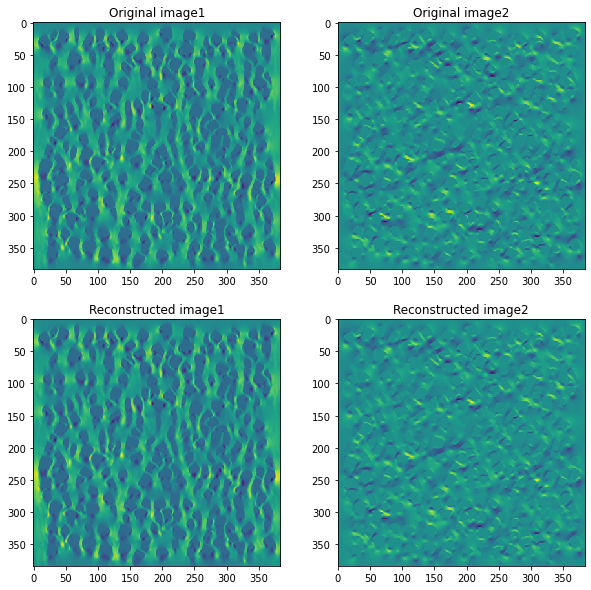

In [14]:
autoencoder.cpu().eval()

# Testing set

# dataP = samples_2steps[0]
dataP = concatenated_data[40]
# dataP = data[:2]
print(dataP.shape, dataP.shape[-1]*dataP.shape[-2]*dataP.shape[-3])

size_start = 0
size_end = xysize

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(10, 10))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')

sub2 = axarr[0][1].imshow(np.rot90(dataP[1, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 2, xysize, xysize))
print('latent space shape', latent_space_output.shape, latent_space_output.shape[-1]*latent_space_output.shape[-2]*latent_space_output.shape[-3])
res = autoencoder(input_data.view(1, 2, xysize, xysize))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')

sub4 = axarr[1][1].imshow(output_data[0,1, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')